In [1]:
import pandas as pd
import numpy as np
import random
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from catalyst.data.sampler import BalanceClassSampler

import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(level=20)

In [2]:
# seed everything

seed = 55555

random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    logging.info(f'Running on {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')

INFO:root:Running on GeForce GTX 1060 6GB


In [4]:
usualtraffic = [pd.read_csv("data\Monday-WorkingHours.pcap_ISCX.csv", encoding = "cp1252"),
                pd.read_csv("data\Tuesday-WorkingHours.pcap_ISCX.csv", encoding = "cp1252"),
                pd.read_csv("data\Wednesday-workingHours.pcap_ISCX.csv", encoding = "cp1252")]
usualtraffic = pd.concat(usualtraffic)

ddos = pd.read_csv("data\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", encoding = "cp1252")
portscan = pd.read_csv("data\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", encoding = "cp1252")
infilteration = pd.read_csv("data\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", encoding = "cp1252")
webattacks = pd.read_csv("data\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", encoding = "cp1252")
# initial webattack csv had several lines of commas with no info, deleted them manually

dataset = pd.concat([usualtraffic, ddos, portscan, infilteration, webattacks], ignore_index = True).sample(frac = 1)
dataset.rename(columns={" Label" : "Label"}, inplace=True)

# dropping flow ID as it provides no useful information
dataset.drop("Flow ID", axis = 1, inplace = True)
dataset.reset_index(drop=True, inplace=True)

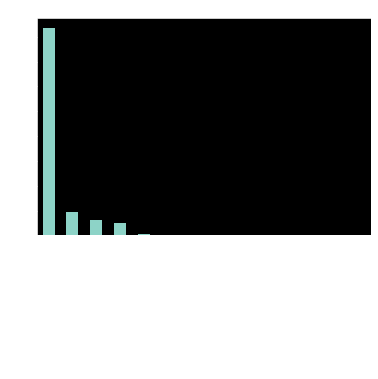

In [6]:
dataset["Label"].value_counts().plot.bar()

In [7]:
# splitting IP columns into 4 columns each to pass to NN

source_ip_split = dataset[" Source IP"].str.split(pat = ".", expand = True)
destination_ip_split = dataset[" Destination IP"].str.split(pat = ".", expand = True)

source_ip_split.rename(columns={0 : "Source IP 0", 1 : "Source IP 1", 2 : "Source IP 2", 3 : "Source IP 3"}, inplace = True)
destination_ip_split.rename(columns={0 : "Destination IP 0", 1 : "Destination IP 1", 2 : "Destination IP 2", 3 : "Destination IP 3"}, inplace = True)

dataset = pd.concat([source_ip_split, destination_ip_split, dataset], axis = 1)
dataset.drop([" Source IP", " Destination IP"], axis = 1, inplace = True)

In [9]:
# split timestamp columns into several columns to pass to NN

dataset[" Timestamp"] = dataset[" Timestamp"].astype('str')
dataset[" Timestamp"] = dataset[" Timestamp"].apply(lambda x: x.replace("/", " ").replace(":", " "))

timestamp_split = dataset[" Timestamp"].str.split(pat = " ", expand = True)
timestamp_split.rename(columns={0 : "Timestamp 0",
                                1 : "Timestamp 1",
                                2 : "Timestamp 2",
                                3 : "Timestamp 3",
                                4 : "Timestamp 4",
                                5 : "Timestamp 5"}, inplace = True)


for col in timestamp_split.columns:
    timestamp_split[col].fillna(value = 0, inplace = True)

dataset = pd.concat([timestamp_split, dataset], axis = 1)
dataset.drop(" Timestamp", axis = 1, inplace = True)

In [13]:
# encoding labels
le = LabelEncoder()
dataset["Label"] = le.fit_transform(dataset["Label"].values)

In [12]:
r0 = dataset["Label"].value_counts()[0]/dataset["Label"].value_counts().sum()
logging.info(f"r0: {r0}")

INFO:root:r0: 0.7894920275333275


In [16]:
# casting everything but labels to float, dropping infs and nans
dataset = dataset.astype("float")
dataset["Label"] = dataset["Label"].astype("int")
dataset = dataset.replace([np.inf, -np.inf], np.nan).dropna()

In [60]:
# creating train, validation and test sets
train_df, val_df = train_test_split(dataset, shuffle = True,
                                                    test_size = 0.3,
                                                    random_state = seed)

val_df, test_df = train_test_split(val_df, shuffle = True,
                                                    test_size = 0.5,
                                                    random_state = seed)


In [61]:
# reducing the dominant class' number of samples

temp_df = train_df[train_df["Label"] == 0]
temp_df = temp_df.sample(n=train_df["Label"].value_counts()[3])
train_df = train_df[train_df["Label"] != 0]
train_df = pd.concat([train_df, temp_df])

In [62]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        super().__init__()
        self.df_data = torch.from_numpy(df.drop("Label", axis = 1).values)
        self.df_labels = torch.from_numpy(df["Label"].values)

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):        
        sample, label = self.df_data[index], self.df_labels[index]

        return sample, label

train_dataset, val_dataset, test_dataset = Dataset(train_df), Dataset(val_df), Dataset(test_df)

In [64]:
batch_size = 64
learning_rate = 0.00005
epochs = 50

In [65]:
# balanced class sampler upsamples everything to the dominant class' sample number
# it increases training time, for that reason some dominant class' samples were removed

train_dataloader = DataLoader(
            train_dataset,
            sampler=BalanceClassSampler(labels = train_df["Label"].values, mode = "upsampling"),
            #sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

valid_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size)

test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size)

In [66]:
class Net(nn.Module):
    def __init__(self, input_size = 94, output_size = 14):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, 512)
        self.fc6 = nn.Linear(512, output_size) 

        self.dropout = nn.Dropout(0.1)   
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.dropout(F.relu(self.fc5(x)))
        x = self.fc6(x)

        return x

net = Net().to(device)

In [67]:
# training loop

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr = learning_rate, weight_decay = 0.999, betas = (0.9, 0.999))

def training_loop(epochs = epochs, net = net):
    best_model_wts = copy.deepcopy(net.state_dict())
    best_loss = 100
    
    for epoch in (range(epochs)):
        print(f'Epoch {epoch+1}')
        train_losses, train_accuracies = train(net)        
        val_losses, val_accuracies = validate(net)        
        print(f'Training accuracy:   {sum(train_accuracies)/len(train_accuracies)} | Training loss: {sum(train_losses)/len(train_losses)}')
        print(f'Validation accuracy: {sum(val_accuracies)/len(val_accuracies)} | Validation loss: {sum(val_losses)/len(val_losses)}')
        
        epoch_val_loss = sum(val_losses)/len(val_losses)
        
        if best_loss > epoch_val_loss:    
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(net.state_dict())
            torch.save(net.state_dict(), 'best.pth')
            print('saving with loss of {}'.format(epoch_val_loss), 'improved over previous {}'.format(best_loss))

In [68]:
def fwd_pass(X, y, step, train = False):           
    outputs = net(X)
    matches = [torch.argmax(i) == j for i, j in zip(outputs,y)]        
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    if train:
        loss.backward()        
        optimizer.step()        
        optimizer.zero_grad()
    return acc, loss

def train(net):
    net.train()
    train_losses = []
    train_accuracies = []
    print("Training")
    for step, batch in (enumerate(train_dataloader)):
        inputs = batch[0].to(device).float()
        labels = batch[1].to(device).long()    
        acc, loss = fwd_pass(inputs, labels, step, train = True)
        if step > 0 and step % 500 == 0:            
            print(f"Step {step} of {len(train_dataloader)}, Accuracy: {sum(train_accuracies)/len(train_accuracies)}, Loss: {sum(train_losses)/len(train_losses)}")
               
        train_losses.append(loss)
        train_accuracies.append(acc)
    return train_losses, train_accuracies               
                
def validate(net):    
    net.eval()
    val_losses = []
    val_accuracies = []
    print("Validation")
    for step, batch in enumerate(valid_dataloader):            
        valid_inputs = batch[0].to(device).float()
        valid_labels = batch[1].to(device).long()
    with torch.no_grad():
        val_acc, val_loss =  fwd_pass(valid_inputs, valid_labels, step, train = False)
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)        
    return val_losses, val_accuracies

In [69]:
training_loop(epochs = 5)

Epoch 1
Training
Step 500 of 35271, Accuracy: 0.53478125, Loss: 5989.9443359375
Step 1000 of 35271, Accuracy: 0.593859375, Loss: 3560.22802734375
Step 1500 of 35271, Accuracy: 0.6243125, Loss: 2527.628662109375
Step 2000 of 35271, Accuracy: 0.6445234375, Loss: 1960.9146728515625
Step 2500 of 35271, Accuracy: 0.65935625, Loss: 1598.13623046875
Step 3000 of 35271, Accuracy: 0.6695520833333334, Loss: 1345.9698486328125
Step 3500 of 35271, Accuracy: 0.6762366071428572, Loss: 1160.712158203125
Step 4000 of 35271, Accuracy: 0.6816875, Loss: 1019.61572265625
Step 4500 of 35271, Accuracy: 0.685875, Loss: 907.9756469726562
Step 5000 of 35271, Accuracy: 0.688853125, Loss: 818.1435546875
Step 5500 of 35271, Accuracy: 0.690659090909091, Loss: 744.351318359375
Step 6000 of 35271, Accuracy: 0.6915989583333333, Loss: 682.6442260742188
Step 6500 of 35271, Accuracy: 0.69259375, Loss: 630.328369140625
Step 7000 of 35271, Accuracy: 0.6943035714285715, Loss: 585.4241333007812
Step 7500 of 35271, Accuracy:

In [70]:
net.load_state_dict(torch.load("best.pth"))

<All keys matched successfully>

In [71]:
def test_f1():
    pred_labels = None
    true_labels = None

    for batch in test_dataloader:
        preds = net(batch[0].float().to(device))
        preds = preds.cpu().detach().numpy()
        #print(preds)
        trues = batch[1].cpu().detach().numpy()
        if pred_labels is not None:
            pred_labels = np.concatenate((pred_labels, preds), axis=0)
        else:
            pred_labels = preds
        
        if true_labels is not None:
            true_labels = np.concatenate((true_labels, trues), axis=0)
        else:        
            true_labels = trues

    pred_labels = [np.argmax(i) for i in pred_labels]
    score = f1_score(true_labels, pred_labels, average='weighted')

    return score


In [85]:
print(f"Weighted f1 score over 14 labels is: {test_f1()}")

Weighted f1 score over 14 labels is: 0.9405858566646059


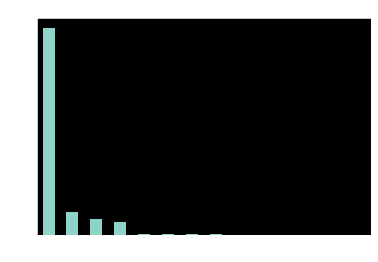

In [79]:
# making sure the label distribution is the same for initial dataset and test df
# dataset["Label"].value_counts().plot.bar()
# test_df["Label"].value_counts().plot.bar()
# val_df["Label"].value_counts().plot.bar()